In [1]:
%reload_ext autoreload
%autoreload 2

### Maximum Monthly Mean climatology
NOAA description [here](https://coralreefwatch.noaa.gov/product/5km/tutorial/crw06a_climatology.php):
> We then defined the Maximum Monthly Mean (MMM) SST climatology. This is the warmest of the 12 monthly mean SST climatology values for each satellite pixel around the world, indicating the upper limit of "usual" temperature.

Outlined in more detail on that page and in [this paper](https://www.mdpi.com/2072-4292/12/23/3856):
> So how did we create the 5km climatology? By following these steps:
>
> 1. We calculated the mean (average) SST for each individual calendar month between 1985 and 2012 for each individual satellite pixel in the world’s oceans.
>
> 2. Next, for each calendar month, we calculated both (a) an initial 28-year monthly mean climatology, and (b) the linear regression of the monthly average temperatures over the 28-year period (1985-2012) of the CoralTemp SST dataset.
>
>   [FROM THE PAPER] The monthly mean (MM) climatology is a set of 12 SST values that represent the average SST for each month calculated over the period 1985 to 2012, adjusted to 1988.2857 (being the average of the years used in the original climatology, i.e., 1985–1990 and 1993). To achieve this, the daily SST values in each month were averaged to produce 12 mean SST values for each of the 28 years from 1985 to 2012. A least squares linear regression was then applied to each month, e.g., the 28 values for each of the Januaries (Y-values) were regressed against the years (X-values), and the SST value corresponding to X = 1988.2857 was assigned as the MM value for January for each 0.05 × 0.05 degree pixel separately.
>
> 3. Finally, we re-centered the initial 28-year monthly mean climatology for a calendar month, from the time center (temporal mid-point) of 1985-2012 (which is 1998.5), to the time-center of 1985-1990 plus 1993 (which is 1988.286). The resulting, final climatology has a baseline (reference) time period of 1985-1990 plus 1993 only.
>
> 4. The 12 monthly mean SST climatologies described in step 3 above are used to derive CRW's daily global 5km SST Anomaly product. The maximum satellite pixel-based values from among the 12 monthly mean SST climatologies form the MMM SST climatology. We use the MMM SST climatology to derive CRW's daily global 5km Coral Bleaching HotSpot and Degree Heating Week (DHW) products. The MMM SST climatology is static in time but varies in space (Strong et al., 1997).


N.B. for larger datasets (the whole world) will be more efficient to extract points for each timeseries before computing metrics. But wouldn't be able to visualise the whole spatial distribution.

In [2]:
# lazy load sst
import calendar
import xarray as xa
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

from bleachbench.utils import config, utils, fileops
from bleachbench.plotting import spatial

In [3]:
sst_fps = [nc_file 
            for subdir in config.crw_sst_dir.iterdir() 
            if subdir.is_dir() and "patch" in subdir.name
            for nc_file in subdir.rglob("*.nc")]
ssts_ds = xa.open_mfdataset(sst_fps, chunks={"time": 12}, join="outer")
ssts_ds_historical = ssts_ds.sel(time=slice(pd.to_datetime("1985-01-01"), pd.to_datetime("2012-12-31")))

In [4]:
sst_monthly = ssts_ds.resample(time="1ME").mean("time", skipna=True)

dates = pd.to_datetime(sst_monthly.time.values)

for year in tqdm(dates.year.unique()):
    save_fp = config.crw_sst_dir / "processed" / f"monthly_means_{year}.nc"
    if save_fp.exists():
        continue
    sst_monthly_year = sst_monthly.sel(time=slice(f"{year}-01-01", f"{year}-12-31"))
    print("Computing...")
    sst_monthly_year = sst_monthly_year.compute()
    print("Saving...")
    sst_monthly_year.to_netcdf(config.crw_sst_dir / "processed" / f"monthly_means_{year}.nc")
print("All files saved to disc.")

  0%|          | 0/32 [00:00<?, ?it/s]

All files saved to disc.


In [5]:
# load monthly means
monthly_means = xa.open_mfdataset((config.crw_sst_dir / "processed").glob("monthly_means_*.nc"), chunks={"time": 12}, join="outer")

In [6]:
### follow NOAA's recipe

# 0.1 calculate temporal midpoint of 1985-2012
mp_1985_2012 = np.mean([1985, 2012])
# 0.2 calculate  temporal midpoint of 1985-1990 plus 1993
mp_1985_1990_1993 = np.mean(np.concat([np.arange(1985, 1990+1), np.array([1993])], axis=0))

# 1.1 group by month and average for years between 1985 and 2012
monthly_clim = ssts_ds_historical["CRW_SST"].groupby("time.month").mean("time", skipna=True)

In [7]:
### calculate monthly means, a la NOAA's recipe
save_fp = config.crw_sst_dir / "processed" / "mm.nc"
if not save_fp.exists():
    num_months = 12
    _, num_lats, num_lons = monthly_means.CRW_SST.shape

    mm = xa.Dataset(
        coords={
            "month": np.arange(1, num_months+1),
            "latitude": monthly_means.latitude,
            "longitude": monthly_means.longitude,
        },
        data_vars={
            "slope": (("month", "latitude", "longitude"), np.zeros((num_months, num_lats, num_lons)), {
                "units": "°C/year",
                "long_name": "slope of linear regression of monthly average temperatures over the 28-year period (1985-2012)",
            }),
            "intercept": (("month", "latitude", "longitude"), np.zeros((num_months, num_lats, num_lons)), {
                "units": "°C",
                "long_name": "intercept of linear regression of monthly average temperatures over the 28-year period (1985-2012)",
            }),
            "prediction": (("month", "latitude", "longitude"), np.zeros((num_months, num_lats, num_lons)), {
                "units": "°C",
                "long_name": "predicted value of monthly average temperatures at 1988.2857",
            }),
        }
    )
    for m_i in tqdm(np.arange(1, 13)):
        slope, intercept = utils.regress_climatology(monthly_means.CRW_SST.sel(time=monthly_means['time'].dt.month == m_i))
        mm.slope.loc[dict(month=m_i)] = slope.values
        mm.intercept.loc[dict(month=m_i)] = intercept.values
        mm.prediction.loc[dict(month=m_i)] = utils.predict_climatology(slope, intercept, mp_1985_1990_1993)
    
    
    print("Saving file to disc...")
    mm.to_netcdf(save_fp)
else:
    print("Loading file from disc...")
    mm = xa.open_dataset(save_fp)

Loading file from disc...


In [8]:
### calculate maximum monthly mean and the index of the month in which it occurs 
mmm = mm.max("month")

save_fp = config.crw_sst_dir / "processed" / "mmm.nc"
if not save_fp.exists():
    mmm.to_netcdf(save_fp)
else:
    mmm = xa.open_dataset(save_fp)

In [9]:
save_fp = config.crw_sst_dir / "processed" / "month_of_mmm.nc"
if not save_fp.exists():
    is_max = mm == mmm  # mask each month's field where it's equal to the max
    month_of_mmm = (is_max * mm["month"]).max("month")
    month_of_mmm = month_of_mmm.where(mm.notnull().any("month"))
    month_of_mmm.to_netcdf(save_fp)
else:
    month_of_mmm = xa.open_dataset(save_fp)

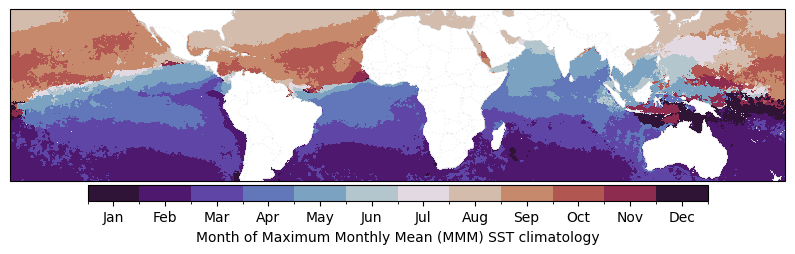

In [10]:
### plot the indices of the month in which the maximum monthly mean occurs
shifted_cmap = plt.get_cmap("twilight_shifted", 13)
norm = mcolors.BoundaryNorm(np.arange(0.5, 13.5, 1), shifted_cmap.N)
month_labels = [calendar.month_name[i][:3] for i in range(1, 13)]

fig, ax = plt.subplots(
    1, 1, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 5)
)
p = month_of_mmm['prediction'].plot(
    ax=ax,
    cmap=shifted_cmap,
    norm=norm,
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
        "ticks": np.arange(1, 13),
        "label": "Month of Maximum Monthly Mean (MMM) SST climatology",
        'orientation': 'horizontal',
        'shrink': 0.8,
        'pad': 0.01,
        'aspect': 40,
    },
)

# replace tick labels with month names
p.colorbar.ax.set_xticklabels(month_labels)
spatial.format_geo_axes(
    ax,
    extent=(
        *utils.get_bounds(month_of_mmm, "longitude"),
        *utils.get_bounds(month_of_mmm, "latitude"),
    ),
)
plt.show()